In [1]:
import cv2
import numpy as np
from PIL import Image
import io
from IPython.display import display
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
import os
# Specify the root directory path
root_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

# Collect all the person names
dir_names = os.listdir(root_path)
person_names = [name.split("_")[-1].title() for name in dir_names]
n_individuals = len(person_names)

print(f"Total number of individuals: {n_individuals}\n")
print(f"Name of the individuals : \n\t{person_names}")

Total number of individuals: 105

Name of the individuals : 
	['Alex Lawther', 'Logan Lerman', 'Maria Pedraza', 'Anthony Mackie', 'Bobby Morley', 'Chris Evans', 'Chris Pratt', 'Mark Zuckerberg', 'Anne Hathaway', 'Emilia Clarke', 'Cristiano Ronaldo', 'Josh Radnor', 'Henry Cavil', 'Zoe Saldana', 'Ellen Page', 'Gwyneth Paltrow', 'Natalie Dormer', 'Barbara Palvin', 'Krysten Ritter', 'Elon Musk', 'Leonardo Dicaprio', 'Bill Gates', 'Elizabeth Olsen', 'Megan Fox', 'Taylor Swift', 'Tom Hiddleston', 'Jeremy Renner', 'Melissa Fumero', 'Robert Downey Jr', 'Amber Heard', 'Jake Mcdorman', 'Robert De Niro', 'Grant Gustin', 'Jennifer Lawrence', 'Eliza Taylor', 'Scarlett Johansson', 'Marie Avgeropoulos', 'Brenton Thwaites', 'Adriana Lima', 'Amanda Crew', 'Hugh Jackman', 'Katherine Langford', 'Camila Mendes', 'Selena Gomez', 'Avril Lavigne', 'Jeff Bezos', 'Jimmy Fallon', 'Christian Bale', 'Shakira Isabel Mebarak', 'Alvaro Morte', 'Lindsey Morgan', 'Zac Efron', 'Dominic Purcell', 'Barack Obama', 'Tom Ho

In [3]:
# Number of images available per person
n_images_per_person = [len(os.listdir(root_path +'/'+ name)) for name in dir_names]
n_images = sum(n_images_per_person)

# Show
print(f"Total Number of Images : {n_images}.")

Total Number of Images : 17534.


In [4]:

IMG_W, IMG_H, IMG_C = (160, 160, 3)
# Select all the file paths
filepaths = [path  for name in dir_names for path in glob(root_path +'/'+name + '/*')]
np.random.shuffle(filepaths)
print(f"Total number of images to be loaded : {len(filepaths)}")

# Create space for the images
all_images = np.empty(shape=(len(filepaths), IMG_W, IMG_H, IMG_C), dtype = np.float32)
all_labels = np.empty(shape=(len(filepaths), 1), dtype = np.int32)

# For each path, load the image and apply some preprocessing.
for index, path in tqdm(enumerate(filepaths), desc="Loading Data"):

    # Extract label
    label = [name[5:] for name in dir_names if name in path][0]
    label = person_names.index(label.title())

    # Load the Image
    image = plt.imread(path)

    # Resize the image
    image = cv2.resize(image, dsize = (IMG_W, IMG_H))

    # Convert image stype
    image = image.astype(np.float32)/255.0

    # Store the image and the label
    all_images[index] = image
    all_labels[index] = label

Total number of images to be loaded : 17534


Loading Data: 17534it [01:39, 175.41it/s]


In [5]:
def show_data(
    images: np.ndarray,
    labels: np.ndarray,
    GRID: tuple=(15,6),
    FIGSIZE: tuple=(25,50),
    recog_fn = None,
    database = None
) -> None:

    # Plotting Configuration
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols

    # loop over the images and labels
    for index in range(n_images):

        # Select image in the corresponding label randomly
        image_index = np.random.randint(len(images))
        image, label = images[image_index], person_names[int(labels[image_index])]

        # Create a Subplot
        plt.subplot(n_rows, n_cols, index+1)

        # Plot Image
        plt.imshow(image)
        plt.axis('off')

        if recog_fn is None:
            # Plot title
            plt.title(label)
        else:
            recognized = recog_fn(image, database)
            plt.title(f"True:{label}\nPred:{recognized}")

    # Show final Plot
    plt.tight_layout()
    plt.show()

In [6]:
# show_data(images = all_images, labels = all_labels)

In [7]:
all_images.shape

(17534, 160, 160, 3)

In [8]:
all_labels.shape

(17534, 1)

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#split data
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2)

# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=105)
y_test_encoded = to_categorical(y_test, num_classes=105)


2024-04-14 10:56:40.807542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 10:56:40.807684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 10:56:40.936580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def data_generator(images, labels, batch_size):
    num_samples = len(images)
    while True:
        # Shuffle the data
        indices = np.random.permutation(num_samples)
        images_shuffled = images[indices]
        labels_shuffled = labels[indices]

        # Generate batches
        for i in range(0, num_samples, batch_size):
            batch_images = images_shuffled[i:i+batch_size]
            batch_labels = labels_shuffled[i:i+batch_size]

            # Preprocess data if needed (e.g., resizing images)
            # batch_images_processed = preprocess_images(batch_images)

            # Yield batch
            yield batch_images, batch_labels

# Define batch size
batch_size = 32

# Create generators for training and validation data
train_generator = data_generator(x_train, y_train_encoded, batch_size)
validation_generator = data_generator(x_test, y_test_encoded, batch_size)


In [11]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten

In [13]:
import h5py

# Open the weights file
with h5py.File("/kaggle/input/inception-v3-weights/inception_v3_weights_tf_dim_ordering_tf_kernels.h5", "r") as f:
    # Get the keys (layer names)
    layer_names = list(f.keys())
    print(layer_names)

['activation_1', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_2', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_3', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_4', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49', 'activation_5', 'activation_50', 'activation_51', 'activation_52', 'activation_53', 'activation_54', 'activation_55', 'activation_56', 'activation_57', 'activation_58', 'activation_59', 'activation_6', 'activation_60', 'activation_61', 'activation_62', 'a

In [14]:
base_model = InceptionV3(input_shape = (160,160,3),weights=None,include_top = True)

In [15]:
base_model.load_weights("/kaggle/input/inception-v3-weights/inception_v3_weights_tf_dim_ordering_tf_kernels.h5")


In [16]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop,Adam
for layer in base_model.layers:
     layer.trainable = False

#pre_trained_model.summary()
last_layer = base_model.get_layer('mixed6')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(256, activation='elu')(x)
# x = layers.Dropout(0.15)(x)
x = layers.Dense(128, activation='elu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(105, activation='softmax')(x)
model = Model(base_model.input, x)
learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.8
)
model.compile(optimizer = Adam(learning_rate=learning_rate_schedule),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 79,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 79, 79,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 79, 79,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 77, 77,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 77, 77,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 77, 77,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 77, 77,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 36, 36,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 36, 36,    │          0 │ batch_normalizat

 Total params: 57,308,809 (218.62 MB)

 Trainable params: 50,477,417 (192.56 MB)

 Non-trainable params: 6,831,392 (26.06 MB)

In [18]:
history=model.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_test,y_test_encoded),batch_size=128)

Epoch 1/20
  2/110 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.0078 - loss: 5.0224  

I0000 00:00:1713092247.584565      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713092247.626476      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0540 - loss: 4.5069

W0000 00:00:1713092265.620559      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713092272.474050      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 298ms/step - accuracy: 0.0544 - loss: 4.5035 - val_accuracy: 0.2846 - val_loss: 3.2650
Epoch 2/20
  1/110 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.3359 - loss: 2.9485

W0000 00:00:1713092280.092441      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.3483 - loss: 2.8354 - val_accuracy: 0.4360 - val_loss: 2.4755
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5733 - loss: 1.8335 - val_accuracy: 0.5178 - val_loss: 2.0131
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.7498 - loss: 1.1455 - val_accuracy: 0.5840 - val_loss: 1.7295
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8536 - loss: 0.7596 - val_accuracy: 0.6242 - val_loss: 1.5684
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9203 - loss: 0.4876 - val_accuracy: 0.6259 - val_loss: 1.5196
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9503 - loss: 0.3479 - val_accuracy: 0.6555 - val_loss: 1.3859
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9709 - loss: 0.2401 - val_accuracy: 0.6681 - val_loss: 1.3558
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9787 - loss: 0.1854 - val_accuracy: 0.668

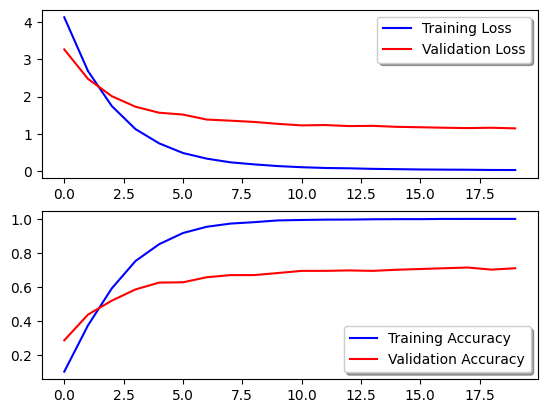

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
# x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.1,random_state=42)
# y_test = to_categorical(y_test, num_classes=105)
# y_val=to_categorical(y_val, num_classes=105)

In [21]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Evaluate the model on the validation data
evaluation = model.evaluate(x_test, y_test_encoded)

# Extract loss and accuracy from the evaluation
loss = evaluation[0]
accuracy = evaluation[1]

print("Loss on validation data:", loss)
print("Accuracy on validation data:", accuracy)


y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.7131 - loss: 1.1463
Loss on validation data: 1.1457810401916504
Accuracy on validation data: 0.7085828185081482
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
Precision: 0.7165693979699311
Recall: 0.7085828343313373
F1 Score: 0.7051609075400812


In [22]:
model.save('face_rec_acc.h5')

In [24]:
del model
del base_model
del all_images
del all_labels
del history